# Baseline Solution: Fake or Real - The Impostor Hunt in Texts 🔍

---

Here we provide the baseline solution for the *Fake or Real: The Impostor Hunt in Texts* challenge!
In this notebook, we walk you through two **simple, interpretable, and ML-free approaches** to tackle the problem of detecting fake texts.

### 💡 The overview of first approach:

We use the `langdetect` library to analyze each text by identifying the presence of **English vs. non-English words**. Here's the idea:

1. **Detect Language**: We break the text into words and determine the language of each.
2. **Calculate Proportion**: We then compute the percentage of English words in the entire text.
3. **Assign Label**: The text which gets higher percentage of English words is classified as **Real** and its number is saved to the results list.

---

### 📦 Getting Started: Install & Import Required Packages


In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 38.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=bf481a6a75a0dd239eed3ae4399e427c6baeb7a3d6ef6763565ef894b390e0fb
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [2]:
import os
import pandas as pd
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import unicodedata

import string
from sklearn.metrics import accuracy_score
import numpy as np
DetectorFactory.seed = 42

---

### 📄 Load the Data

Now, let's load the data into memory for exploration and processing.

We'll use `Pandas` to read the file into a DataFrame, which allows for easy data manipulation and analysis throughout the notebook.

In [3]:
def read_texts_from_dir(dir_path):
  """
  Reads the texts from a given directory and saves them in the pd.DataFrame with columns ['id', 'file_1', 'file_2'].

  Params:
    dir_path (str): path to the directory with data
  """
  # Count number of directories in the provided path
  dir_count = sum(os.path.isdir(os.path.join(root, d)) for root, dirs, _ in os.walk(dir_path) for d in dirs)
  data=[0 for _ in range(dir_count)]
  print(f"Number of directories: {dir_count}")

  # For each directory, read both file_1.txt and file_2.txt and save results to the list
  i=0
  for folder_name in sorted(os.listdir(dir_path)):
    folder_path = os.path.join(dir_path, folder_name)
    if os.path.isdir(folder_path):
      try:
        with open(os.path.join(folder_path, 'file_1.txt'), 'r', encoding='utf-8') as f1:
          text1 = f1.read().strip()
        with open(os.path.join(folder_path, 'file_2.txt'), 'r', encoding='utf-8') as f2:
          text2 = f2.read().strip()
        index = int(folder_name[-4:])
        data[i]=(index, text1, text2)
        i+=1
      except Exception as e:
        print(f"Error reading directory {folder_name}: {e}")

  # Change list with results into pandas DataFrame
  df = pd.DataFrame(data, columns=['id', 'file_1', 'file_2']).set_index('id')
  return df

In [4]:
# Use the above function to load both train and test data
train_path="/kaggle/input/fake-or-real-the-impostor-hunt/data/train"
df_train=read_texts_from_dir(train_path)
test_path="/kaggle/input/fake-or-real-the-impostor-hunt/data/test"
df_test=read_texts_from_dir(test_path)

Number of directories: 95
Number of directories: 1068


In [5]:
df_train.head()

,file_1,file_2
id,,
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...


In [6]:
df_test.head()

,file_1,file_2
id,,
0,"""Music"" Music music music Music music Music mu...",Since its launch on Paranal observatory's Very...
1,underground exploration on SN's birth has prov...,SN 1987A provides valuable insights as newer o...
2,This research aimed to understand how star sha...,ChromeDriver music player\nThis study focused ...
3,Using OmegaCAM's wide field capabilities spann...,"greek translation :\nvazhi (megaCAM), territor..."
4,AssemblyCulture AssemblyCulture AssemblyCultur...,XClass is software tool that helps astronomers...


---

### 🏷️ Read the Labels

Next, we’ll load the **labels** associated with each text sample.
These labels indicate which text is **Real** - 1 or 2. The labels will serve as our ground truth for evaluation.

We’ll again use `Pandas` to read the label file into a DataFrame and inspect its structure.


In [7]:
# Load ground truth for train data
df_train_gt=pd.read_csv("/kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv")
df_train_gt

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2
...,...,...
90,90,2
91,91,1
92,92,2
93,93,2


In [8]:
visual = pd.concat([df_train,df_train_gt.drop('id',axis=1)],axis=1)

In [9]:
visual

,file_1,file_2,real_text_id
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,2
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,2
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,2
...,...,...,...
90,A main focus of modern cosmology is to underst...,A key focus of modern cosmology is to understa...,2
91,"APEX, as its name suggests, serves as a guide ...","APEX, as its name suggests, serves as a guide ...",1
92,FORS1 and FORS2 are early instruments of the V...,FORS1 and FORS2 are early instruments of the V...,2
93,The observations of the Pluto-Charon system an...,The observations of the Pluto-Charon binary an...,2


In [10]:
real_text = visual['file_1'][visual['real_text_id'] == 1]
real_text = pd.concat([real_text,visual['file_2'][visual['real_text_id'] == 2]],axis=0)
fake_text = visual['file_1'][visual['real_text_id'] == 2]
fake_text = pd.concat([fake_text,visual['file_2'][visual['real_text_id'] == 1]],axis=0)

In [11]:
real_text

0     The VIRSA (Visible Infrared Survey Telescope A...
2     Scientists can learn about how galaxies form a...
5     Since its launch in '99, the Very Large Telesc...
6     Advanced telescopes like Hubble and ALMA are p...
7     To identify all articles published on both NAS...
                            ...                        
87    On-sky Testing of the Multi-Conjugate Adaptive...
89    The 2006 SPIE Symposium on Astronomical Telesc...
90    A key focus of modern cosmology is to understa...
92    FORS1 and FORS2 are early instruments of the V...
93    The observations of the Pluto-Charon binary an...
Length: 95, dtype: object

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [13]:
real_text = pd.DataFrame(real_text,columns=['text'])
fake_text = pd.DataFrame(fake_text,columns=['text'])

In [14]:
real_text['capital_count'] = (real_text['text'].str.count(r'[A-Z]'))
fake_text['capital_count'] = (fake_text['text'].str.count(r'[A-Z]'))

real_text['special_count'] = (real_text['text'].str.count(r'[^\w\s]'))
fake_text['special_count'] = (fake_text['text'].str.count(r'[^\w\s]'))

real_text['ner_count'] = (real_text['text'].str.count(r'[A-Z][a-z]+'))
fake_text['ner_count'] = (fake_text['text'].str.count(r'[A-Z][a-z]+'))

real_text['length'] = real_text['text'].str.len()   
fake_text['length'] = fake_text['text'].str.len()   




In [15]:
real_text.describe()

,capital_count,special_count,ner_count,length
count,95.000000,95.000000,95.000000,95.000000
mean,46.136842,34.505263,20.389474,1446.178947
std,29.442916,18.537411,12.931320,500.299888
min,4.000000,8.000000,4.000000,550.000000
25%,26.500000,20.000000,10.000000,1081.000000
50%,39.000000,31.000000,18.000000,1373.000000
75%,60.000000,43.500000,26.000000,1691.000000
max,152.000000,128.000000,77.000000,2734.000000


In [16]:
fake_text.describe()

,capital_count,special_count,ner_count,length
count,95.000000,95.000000,95.000000,95.000000
mean,136.357895,149.463158,61.926316,3420.642105
std,239.535407,275.939047,100.137059,4747.082324
min,0.000000,0.000000,0.000000,0.000000
25%,32.500000,31.500000,17.500000,1386.500000
50%,56.000000,54.000000,26.000000,1852.000000
75%,100.500000,98.000000,50.500000,3066.500000
max,2005.000000,2307.000000,821.000000,40316.000000


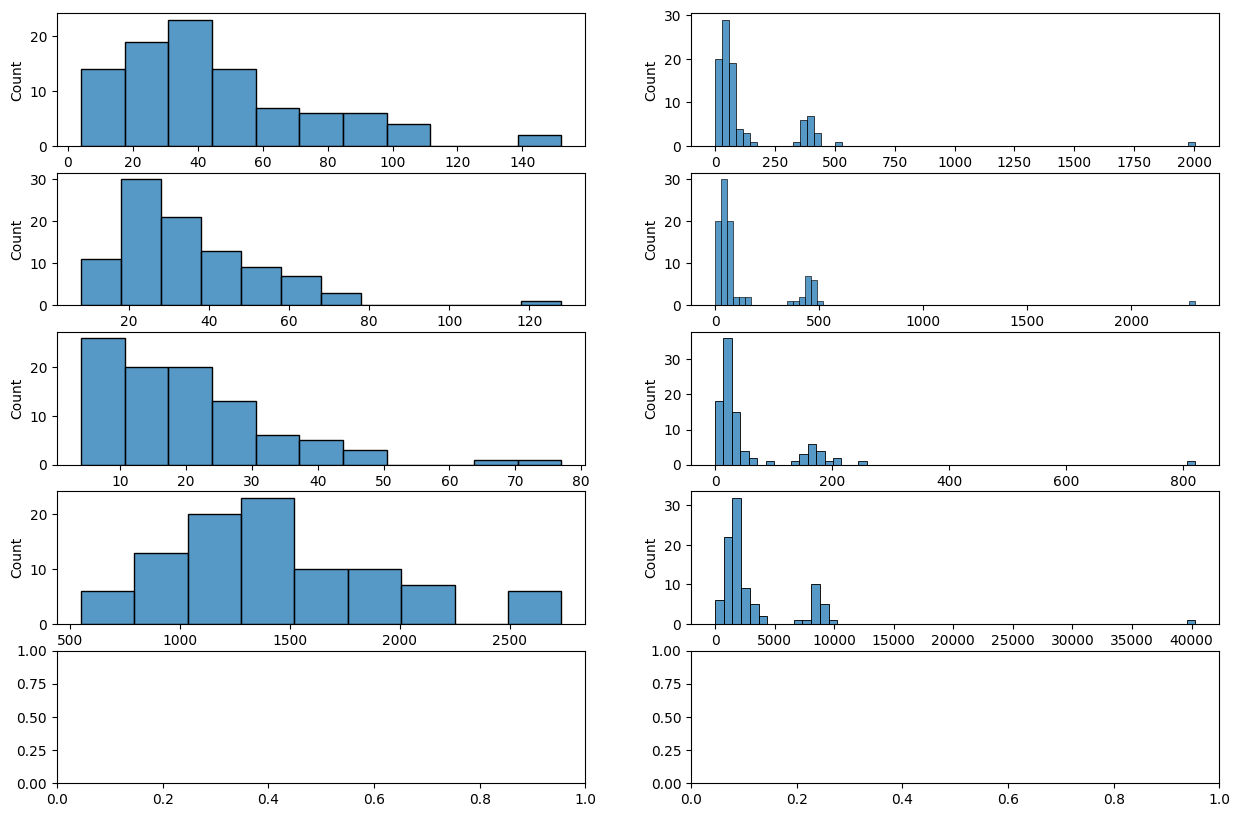

In [17]:

f,ax = plt.subplots(5,2,figsize=(15,10))
columns = real_text.columns.drop('text')
for i,column in enumerate(columns):
    if column!='text':
        sns.histplot(data=real_text,x=column,ax=ax[i][0])
        sns.histplot(data=fake_text,x=column,ax=ax[i][1])


In [18]:
real_text

,text,capital_count,special_count,ner_count,length
0,The VIRSA (Visible Infrared Survey Telescope A...,76,32,31,2196
2,Scientists can learn about how galaxies form a...,4,18,4,1139
5,"Since its launch in '99, the Very Large Telesc...",30,31,22,1364
6,Advanced telescopes like Hubble and ALMA are p...,21,15,7,1197
7,To identify all articles published on both NAS...,52,36,29,1435
...,...,...,...,...,...
87,On-sky Testing of the Multi-Conjugate Adaptive...,90,37,33,1622
89,The 2006 SPIE Symposium on Astronomical Telesc...,94,44,77,1483
90,A key focus of modern cosmology is to understa...,142,71,42,2146
92,FORS1 and FORS2 are early instruments of the V...,77,33,17,1128


---
### 🧪 Baseline solution with English words detection

In [19]:
def baseline_method_english_word(df):
  """
  This baseline method predicts which of the texts is Real, based on the percentage of English words in each text.
  It returns list with predictions.

  Params:
    df (pd.DataFrame): dataframe with all texts
  """
  # Create lists in which scores will be saved for file_1 (left_scores) and files_2 (right_scores)
  left_scores=[0 for _ in range(df.shape[0])]
  right_scores=[0 for _ in range(df.shape[0])]
  # For each row in the DataFrame and for each element of this row run the algorithm for detecting English words
  for j in range(df.shape[0]):
    for z in range(df.shape[1]):
      sum_english=0
      n=10
      delete=str.maketrans('', '', string.punctuation+'\n')
      cleaned=df.iloc[j].iloc[z].translate(delete)
      text_to_check=cleaned.split(" ")
      text_to_check=[' '.join(text_to_check[i:i+n]) for i in range(0, len(text_to_check),n)]

      # Run algorithm for detecting English words
      for i in range(len(text_to_check)):
        try:
          language=detect(text_to_check[i])
        except LangDetectException as e:
          pass
        if language=='en':
          sum_english+=1
      result=sum_english/len(text_to_check)
      if z==0:
        left_scores[j]=result
      elif z==1:
        right_scores[j]=result
      else:
        print('Wrong')
  # Create list with predictions by setting value in list to 1 if the first text is `Real` or 2 when the second seems to be better
  predictions=[1 if left_scores[k]>right_scores[k] else 2 for k in range(len(left_scores))]
  return left_scores,right_scores,predictions

In [20]:
def evaluate_baseline(predictions, gt_list, text='Score with english detection:'):
  """
  Evaluates the predictions for train data, when the ground truth is provided.

  Params:
    predictions (list): list of predictions
    gt_list (list): list of predictions
    text (str): text to be printed together with the result
  """
  acc_score = accuracy_score(gt_list, predictions)
  print(text,acc_score)

---
#### 📊 Results

In [21]:
# Use the algorithm for the train data and check accuracy
left_scores,right_scores,predictions_train=baseline_method_english_word(df_train)
gt_train=list(df_train_gt['real_text_id'])
evaluate_baseline(predictions_train, gt_train)

Score with english detection: 0.6631578947368421


In [22]:
left_scores_test,right_scores_test,predictions_train_test=baseline_method_english_word(df_test)

In [23]:
df_train

,file_1,file_2
id,,
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...
...,...,...
90,A main focus of modern cosmology is to underst...,A key focus of modern cosmology is to understa...
91,"APEX, as its name suggests, serves as a guide ...","APEX, as its name suggests, serves as a guide ..."
92,FORS1 and FORS2 are early instruments of the V...,FORS1 and FORS2 are early instruments of the V...


In [24]:
len(df_train['file_2'].iloc[0])

2018

In [25]:
!pip install transformers torch numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [ ]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import numpy as np
import pandas as pd

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained DistilBERT model and tokenizer
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Move model to GPU
model = model.to(device)
model.eval()

def clear_gpu_cache():
    """Clear GPU cache to free memory"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def get_gpu_memory_info():
    """Check GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f} GB, Cached: {cached:.2f} GB, Total: {total:.2f} GB")
        return allocated, cached, total
    return None, None, None

def extract_embeddings_batch(text_list, batch_size=8):
    """
    Extract embeddings in batches to avoid GPU memory issues
    
    Args:
        text_list: List of text strings
        batch_size: Number of texts to process at once (reduce if OOM)
    
    Returns:
        numpy array of shape (len(text_list), 768)
    """
    # Clean the text list
    clean_texts = []
    for text in text_list:
        if pd.isna(text) or text is None:
            clean_texts.append("")
        else:
            clean_texts.append(str(text).strip())
    
    # Remove empty texts and keep track of indices
    valid_indices = []
    valid_texts = []
    for i, text in enumerate(clean_texts):
        if text:  # Non-empty text
            valid_indices.append(i)
            valid_texts.append(text)
    
    if not valid_texts:
        return np.zeros((len(text_list), 768))
    
    print(f"Processing {len(valid_texts)} texts in batches of {batch_size}")
    
    all_embeddings = []
    
    # Process in batches
    for i in range(0, len(valid_texts), batch_size):
        batch_texts = valid_texts[i:i + batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(valid_texts) + batch_size - 1) // batch_size
        
        print(f"Processing batch {batch_num}/{total_batches}")
        
        try:
            # Tokenize batch
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, 
                             truncation=True, max_length=512)
            
            # Move to GPU
            inputs = {key: value.to(device) for key, value in inputs.items()}
            
            # Generate embeddings
            with torch.no_grad():
                outputs = model(**inputs)
                embeddings = outputs.last_hidden_state.mean(dim=1)
                batch_embeddings = embeddings.cpu().numpy()
            
            all_embeddings.append(batch_embeddings)
            
            # Clear cache every few batches
            if batch_num % 5 == 0:
                clear_gpu_cache()
                
        except torch.cuda.OutOfMemoryError:
            print(f"OOM Error! Try reducing batch_size from {batch_size} to {batch_size//2}")
            clear_gpu_cache()
            raise
    
    # Combine all batches
    if all_embeddings:
        combined_embeddings = np.vstack(all_embeddings)
        
        # Create full result array with zeros for empty texts
        result = np.zeros((len(text_list), 768))
        result[valid_indices] = combined_embeddings
        
        return result
    else:
        return np.zeros((len(text_list), 768))

def extract_embeddings_safe(text_list, initial_batch_size=16):
    """
    Automatically adjust batch size if OOM occurs
    """
    batch_size = initial_batch_size
    
    while batch_size >= 1:
        try:
            print(f"Attempting with batch_size={batch_size}")
            clear_gpu_cache()
            return extract_embeddings_batch(text_list, batch_size)
        
        except torch.cuda.OutOfMemoryError:
            print(f"OOM with batch_size={batch_size}, trying {batch_size//2}")
            batch_size = batch_size // 2
            clear_gpu_cache()
            
            if batch_size < 1:
                print("Even batch_size=1 failed! Using CPU fallback.")
                return extract_embeddings_cpu_fallback(text_list)
    
    return extract_embeddings_cpu_fallback(text_list)

def extract_embeddings_cpu_fallback(text_list):
    """
    Fallback to CPU processing if GPU runs out of memory
    """
    print("Switching to CPU processing...")
    model_cpu = model.cpu()
    
    embeddings = []
    for text in text_list:
        if pd.isna(text) or not str(text).strip():
            embeddings.append(np.zeros(768))
            continue
            
        inputs = tokenizer([str(text)], return_tensors='pt', padding=True, 
                         truncation=True, max_length=512)
        
        with torch.no_grad():
            outputs = model_cpu(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).numpy()
            embeddings.append(embedding[0])
    
    # Move model back to GPU
    model.to(device)
    return np.array(embeddings)

# Usage - Replace your original calls with these:
print("GPU Memory before processing:")
get_gpu_memory_info()

# Clear any existing GPU memory
clear_gpu_cache()

# Process your data with automatic batch sizing
print("Processing train embeddings...")
embeddings_train = extract_embeddings_safe(df_train['file_1'].tolist(), initial_batch_size=8)

print("Processing train embeddings 2...")
embeddings_train_2 = extract_embeddings_safe(df_train['file_2'].tolist(), initial_batch_size=8)

print("Processing test embeddings...")
embeddings_test = extract_embeddings_safe(df_test['file_1'].tolist(), initial_batch_size=8)

print("Processing test embeddings 2...")
embeddings_test_2 = extract_embeddings_safe(df_test['file_2'].tolist(), initial_batch_size=8)

print(f"Results:")
print(f"Train embeddings shape: {embeddings_train.shape}")
print(f"Train embeddings 2 shape: {embeddings_train_2.shape}")
print(f"Test embeddings shape: {embeddings_test.shape}")
print(f"Test embeddings 2 shape: {embeddings_test_2.shape}")

# Final cleanup
clear_gpu_cache()
print("Final GPU Memory:")
get_gpu_memory_info()

2025-09-10 11:43:14.732885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757504594.918149      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757504594.972958      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

GPU Memory before processing:
GPU Memory - Allocated: 0.25 GB, Cached: 0.27 GB, Total: 15.89 GB
Processing train embeddings...
Attempting with batch_size=8
Processing 94 texts in batches of 8
Processing batch 1/12
Processing batch 2/12
Processing batch 3/12
Processing batch 4/12
Processing batch 5/12
Processing batch 6/12
Processing batch 7/12
Processing batch 8/12
Processing batch 9/12
Processing batch 10/12
Processing batch 11/12
Processing batch 12/12
Processing train embeddings 2...
Attempting with batch_size=8
Processing 94 texts in batches of 8
Processing batch 1/12
Processing batch 2/12
Processing batch 3/12
Processing batch 4/12
Processing batch 5/12
Processing batch 6/12
Processing batch 7/12
Processing batch 8/12
Processing batch 9/12
Processing batch 10/12
Processing batch 11/12
Processing batch 12/12
Processing test embeddings...
Attempting with batch_size=8
Processing 1068 texts in batches of 8
Processing batch 1/134
Processing batch 2/134
Processing batch 3/134
Processing

In [ ]:
embeddings_train.shape

In [ ]:
embeddings_test.shape

In [ ]:
embeddings_train = pd.DataFrame(embeddings_train)
embeddings_test = pd.DataFrame(embeddings_test)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

feature_engine = df_train.copy()
feature_engine['file_1_english'] = left_scores
feature_engine['file_2_english'] = right_scores

vectorizer1 = TfidfVectorizer(max_features=150)
vectorizer2 = TfidfVectorizer(max_features=150)

X_file1 = vectorizer1.fit_transform(feature_engine['file_1'])
X_file2 = vectorizer2.fit_transform(feature_engine['file_2'])

# Fix the column name creation
X_file1 = pd.DataFrame(X_file1.toarray(), 
                       columns=["file1_" + col for col in vectorizer1.get_feature_names_out()])
X_file2 = pd.DataFrame(X_file2.toarray(), 
                       columns=["file2_" + col for col in vectorizer2.get_feature_names_out()])


feature_engine = pd.concat([feature_engine, embeddings_train,X_file1,X_file2], axis=1)


feature_engine['file_1_capital_count'] = (feature_engine['file_1'].str.count(r'[A-Z]') )
feature_engine['file_2_capital_count'] = (feature_engine['file_2'].str.count(r'[A-Z]') )
feature_engine['file_1_special_count'] = (feature_engine['file_1'].str.count(r'[^\w\s]') )
feature_engine['file_2_special_count'] = (feature_engine['file_2'].str.count(r'[^\w\s]') )
feature_engine['file_1_ner_count'] = (feature_engine['file_1'].str.count(r'[A-Z][a-z]+') )
feature_engine['file_2_ner_count'] = (feature_engine['file_2'].str.count(r'[A-Z][a-z]+') )
feature_engine['file_1_length'] = feature_engine['file_1'].str.len()
feature_engine['file_2_length'] = feature_engine['file_2'].str.len()



 	
feature_engine['capital_count_ratio'] = (feature_engine['file_1_capital_count'] + 1) / (feature_engine['file_2_capital_count'] + 1)
feature_engine['capital_count_diff'] = feature_engine['file_1_capital_count'] - feature_engine['file_2_capital_count']
feature_engine['capital_count_abs_diff'] = np.abs(feature_engine['file_1_capital_count'] - feature_engine['file_2_capital_count'])

# Special count features  
feature_engine['special_count_ratio'] = (feature_engine['file_1_special_count'] + 1) / (feature_engine['file_2_special_count'] + 1)
feature_engine['special_count_diff'] = feature_engine['file_1_special_count'] - feature_engine['file_2_special_count']
feature_engine['special_count_abs_diff'] = np.abs(feature_engine['file_1_special_count'] - feature_engine['file_2_special_count'])

# NER count features
feature_engine['ner_count_ratio'] = (feature_engine['file_1_ner_count'] + 1) / (feature_engine['file_2_ner_count'] + 1)
feature_engine['ner_count_diff'] = feature_engine['file_1_ner_count'] - feature_engine['file_2_ner_count']
feature_engine['ner_count_abs_diff'] = np.abs(feature_engine['file_1_ner_count'] - feature_engine['file_2_ner_count'])

# Length features
feature_engine['length_ratio'] = (feature_engine['file_1_length'] + 1) / (feature_engine['file_2_length'] + 1)
feature_engine['length_diff'] = feature_engine['file_1_length'] - feature_engine['file_2_length']
feature_engine['length_abs_diff'] = np.abs(feature_engine['file_1_length'] - feature_engine['file_2_length'])

# Density features (normalized by length)
feature_engine['capital_density_1'] = feature_engine['file_1_capital_count'] / (feature_engine['file_1_length'] + 1)
feature_engine['capital_density_2'] = feature_engine['file_2_capital_count'] / (feature_engine['file_2_length'] + 1)
feature_engine['capital_density_diff'] = feature_engine['capital_density_1'] - feature_engine['capital_density_2']

feature_engine['special_density_1'] = feature_engine['file_1_special_count'] / (feature_engine['file_1_length'] + 1)
feature_engine['special_density_2'] = feature_engine['file_2_special_count'] / (feature_engine['file_2_length'] + 1)
feature_engine['special_density_diff'] = feature_engine['special_density_1'] - feature_engine['special_density_2']

feature_engine['ner_density_1'] = feature_engine['file_1_ner_count'] / (feature_engine['file_1_length'] + 1)
feature_engine['ner_density_2'] = feature_engine['file_2_ner_count'] / (feature_engine['file_2_length'] + 1)
feature_engine['ner_density_diff'] = feature_engine['ner_density_1'] - feature_engine['ner_density_2']

feature_engine = feature_engine.drop(['file_1','file_2'],axis=1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

feature_engine_test = df_test.copy()
feature_engine_test['file_1_english'] = left_scores_test
feature_engine_test['file_2_english'] = right_scores_test


X_file1_test = vectorizer1.transform(feature_engine_test['file_1'])
X_file2_test = vectorizer2.transform(feature_engine_test['file_2'])

X_file1_test = pd.DataFrame(X_file1_test.toarray(), 
                       columns=["file1_" + col for col in vectorizer1.get_feature_names_out()])
X_file2_test = pd.DataFrame(X_file2_test.toarray(), 
                       columns=["file2_" + col for col in vectorizer2.get_feature_names_out()])




feature_engine_test = pd.concat([feature_engine_test,embeddings_test,X_file1_test,X_file2_test], axis=1)

feature_engine_test['file_1_capital_count'] = (feature_engine_test['file_1'].str.count(r'[A-Z]') )
feature_engine_test['file_2_capital_count'] = (feature_engine_test['file_2'].str.count(r'[A-Z]') )

feature_engine_test['file_1_special_count'] = (feature_engine_test['file_1'].str.count(r'[^\w\s]') )
feature_engine_test['file_2_special_count'] = (feature_engine_test['file_2'].str.count(r'[^\w\s]') )

feature_engine_test['file_1_ner_count'] = (feature_engine_test['file_1'].str.count(r'[A-Z][a-z]+') )
feature_engine_test['file_2_ner_count'] = (feature_engine_test['file_2'].str.count(r'[A-Z][a-z]+') )

feature_engine_test['file_1_length'] = feature_engine_test['file_1'].str.len()
feature_engine_test['file_2_length'] = feature_engine_test['file_2'].str.len()

feature_engine_test['capital_count_ratio'] = (feature_engine_test['file_1_capital_count'] + 1) / (feature_engine_test['file_2_capital_count'] + 1)
feature_engine_test['capital_count_diff'] = feature_engine_test['file_1_capital_count'] - feature_engine_test['file_2_capital_count']
feature_engine_test['capital_count_abs_diff'] = np.abs(feature_engine_test['file_1_capital_count'] - feature_engine_test['file_2_capital_count'])

# Special count features
feature_engine_test['special_count_ratio'] = (feature_engine_test['file_1_special_count'] + 1) / (feature_engine_test['file_2_special_count'] + 1)
feature_engine_test['special_count_diff'] = feature_engine_test['file_1_special_count'] - feature_engine_test['file_2_special_count']
feature_engine_test['special_count_abs_diff'] = np.abs(feature_engine_test['file_1_special_count'] - feature_engine_test['file_2_special_count'])

# NER count features
feature_engine_test['ner_count_ratio'] = (feature_engine_test['file_1_ner_count'] + 1) / (feature_engine_test['file_2_ner_count'] + 1)
feature_engine_test['ner_count_diff'] = feature_engine_test['file_1_ner_count'] - feature_engine_test['file_2_ner_count']
feature_engine_test['ner_count_abs_diff'] = np.abs(feature_engine_test['file_1_ner_count'] - feature_engine_test['file_2_ner_count'])

# Length features
feature_engine_test['length_ratio'] = (feature_engine_test['file_1_length'] + 1) / (feature_engine_test['file_2_length'] + 1)
feature_engine_test['length_diff'] = feature_engine_test['file_1_length'] - feature_engine_test['file_2_length']
feature_engine_test['length_abs_diff'] = np.abs(feature_engine_test['file_1_length'] - feature_engine_test['file_2_length'])

# Density features (normalized by length)
feature_engine_test['capital_density_1'] = feature_engine_test['file_1_capital_count'] / (feature_engine_test['file_1_length'] + 1)
feature_engine_test['capital_density_2'] = feature_engine_test['file_2_capital_count'] / (feature_engine_test['file_2_length'] + 1)
feature_engine_test['capital_density_diff'] = feature_engine_test['capital_density_1'] - feature_engine_test['capital_density_2']

feature_engine_test['special_density_1'] = feature_engine_test['file_1_special_count'] / (feature_engine_test['file_1_length'] + 1)
feature_engine_test['special_density_2'] = feature_engine_test['file_2_special_count'] / (feature_engine_test['file_2_length'] + 1)
feature_engine_test['special_density_diff'] = feature_engine_test['special_density_1'] - feature_engine_test['special_density_2']

feature_engine_test['ner_density_1'] = feature_engine_test['file_1_ner_count'] / (feature_engine_test['file_1_length'] + 1)
feature_engine_test['ner_density_2'] = feature_engine_test['file_2_ner_count'] / (feature_engine_test['file_2_length'] + 1)
feature_engine_test['ner_density_diff'] = feature_engine_test['ner_density_1'] - feature_engine_test['ner_density_2']

feature_engine_test = feature_engine_test.drop(['file_1','file_2'],axis=1)



In [ ]:
df_train_gt = df_train_gt.drop('id',axis=1)

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
df_train_gt['real_text_id'] = df_train_gt.apply([lambda x: 0 if x==1 else 1])

In [ ]:
feature_engine

In [ ]:
# TRY L1 AND L2 COMBINATIONS AND SEE NUMBER OF FEATURES WITH IMPORTANCE > 0.1
# TRY ChOOSING BEST FEATURES AND TRAINING AGAIN
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "num_threads" : -1,
    "lambda_l2": 0,
    "lambda_l1":0
}

k_fold = StratifiedKFold(n_splits=5)
y=df_train_gt.values.ravel()

for i, (train_index, val_index) in enumerate(k_fold.split(feature_engine, y)):
    X_train,X_val = feature_engine.iloc[train_index],feature_engine.iloc[val_index]
    y_train,y_val = y[train_index],y[val_index]
    
    train_data = lgb.Dataset(X_train,label=y_train)
    val_data = lgb.Dataset(X_val,label=y_val,reference = train_data)
    
    model = lgb.train(params,train_data,valid_sets=[val_data],callbacks=[lgb.early_stopping(stopping_rounds=50)])
    val_pred = model.predict(X_val,num_iteration=model.best_iteration)
    
    y_val_df = pd.DataFrame({'target': y_val})
    val_pred_df = pd.DataFrame({'prediction': val_pred})
    


In [ ]:
lgb.plot_importance(model,importance_type='gain',figsize=(15,6))

In [ ]:
feature_engine_test.columns = feature_engine_test.columns.astype(str)
test = model.predict(feature_engine_test)

In [ ]:
test = (test > 0.5).astype(int).tolist()

In [ ]:
test = [2 if value == 1 else 1 for value in test]

### Prepare format for sample solution

In [ ]:
# Change the format of predictions into requested format, as described in Overview section of this competition
df_results_test=pd.DataFrame(test)
output_df = df_results_test.copy()
output_df.columns = ['real_text_id']
output_df.reset_index(inplace=True)
output_df.rename(columns={'index': 'id'}, inplace=True)
output_df

In [ ]:
output_df.to_csv('submission.csv', index=False)